In [335]:
import pandas as pd
import polars as pl
import plotnine as pn
import numpy as np
from tqdm.notebook import tqdm

import lightgbm as lgb
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import os
import holidays

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


### Data Preparation

Focus on CH spot price first

In [336]:
df = pd.read_csv(
    "../../00 Data Retrieval and Cleaning/0_df_final_ml_predictive.csv",
    parse_dates=["date"],
)
df.head()

,date,auction_price_ch_de,auction_price_de_ch,dst,day_ahead_price_at,day_ahead_price_ch,day_ahead_price_de,day_ahead_price_fr,day_ahead_price_it,actual_load_at,...,wind_offshore_actual_aggregated_it,wind_offshore_forecast_de,wind_onshore_actual_aggregated_at,wind_onshore_actual_aggregated_de,wind_onshore_actual_aggregated_fr,wind_onshore_actual_aggregated_it,wind_onshore_ch,wind_onshore_forecast_at,wind_onshore_forecast_de,wind_onshore_forecast_fr
0,2023-01-01 00:00:00+00:00,0.01,6.09,1,NaN,-7.25,-1.07,NaN,NaN,NaN,...,NaN,3390.25,NaN,NaN,NaN,NaN,NaN,1174.0,35415.50,13933.0
1,2023-01-01 01:00:00+00:00,0.01,5.50,1,NaN,-3.99,-1.47,NaN,NaN,NaN,...,NaN,3395.50,NaN,NaN,NaN,NaN,NaN,1194.0,35146.75,13583.0
2,2023-01-01 02:00:00+00:00,0.01,6.45,1,NaN,-7.71,-5.08,NaN,NaN,NaN,...,NaN,3410.25,NaN,NaN,NaN,NaN,NaN,1085.0,34449.00,13230.0
3,2023-01-01 03:00:00+00:00,0.01,9.08,1,NaN,-9.71,-4.49,NaN,NaN,NaN,...,NaN,3431.25,NaN,NaN,NaN,NaN,NaN,897.0,33905.25,12877.0
4,2023-01-01 04:00:00+00:00,0.01,13.33,1,NaN,-15.15,-5.40,NaN,NaN,NaN,...,NaN,3454.25,NaN,NaN,NaN,NaN,NaN,697.0,33362.75,12311.0


Need to lag the other three target variables by 24 hours, haven't done that yet:

In [337]:
df = (
    df
    .assign(
        day_ahead_price_de=lambda x: x["day_ahead_price_de"].shift(24),
        auction_price_de_ch=lambda x: x["auction_price_de_ch"].shift(24),
        auction_price_ch_de=lambda x: x["auction_price_ch_de"].shift(24),
    )
)

### Include target lags

- latest available price (last price of previous day)
- last two week prices at exact hour (14 additional cols)

In [338]:
# Adding last available price from previous day
df = df.assign(
    day=lambda x: x.date.dt.date,
    day_ahead_price_ch_last=lambda x: x.groupby("day")["day_ahead_price_ch"].transform("last").shift(24),
)

In [339]:
# Adding lags in 24h steps for the last two weeks
lags = np.arange(24, 49).tolist() + (np.arange(3, 15) * 24).tolist()
print(lags)
for i in lags:
    df[f"day_ahead_price_ch_lag_{i}"] = df["day_ahead_price_ch"].shift(i)

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336]


In [340]:
df.filter(regex="day_ahead_price_ch").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9501 entries, 0 to 9500
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   day_ahead_price_ch          9501 non-null   float64
 1   day_ahead_price_ch_last     9477 non-null   float64
 2   day_ahead_price_ch_lag_24   9477 non-null   float64
 3   day_ahead_price_ch_lag_25   9476 non-null   float64
 4   day_ahead_price_ch_lag_26   9475 non-null   float64
 5   day_ahead_price_ch_lag_27   9474 non-null   float64
 6   day_ahead_price_ch_lag_28   9473 non-null   float64
 7   day_ahead_price_ch_lag_29   9472 non-null   float64
 8   day_ahead_price_ch_lag_30   9471 non-null   float64
 9   day_ahead_price_ch_lag_31   9470 non-null   float64
 10  day_ahead_price_ch_lag_32   9469 non-null   float64
 11  day_ahead_price_ch_lag_33   9468 non-null   float64
 12  day_ahead_price_ch_lag_34   9467 non-null   float64
 13  day_ahead_price_ch_lag_35   9466 

### Additional Feature Generation

- There might be a benefit of encoding cyclical calendar information
- Additionally: Holidays

Include a trend column:

In [341]:
df = df.assign(trend=lambda x: x.index)

In [342]:
# Define the country (Switzerland)
country = "CH"

regional_holidays = holidays.CH(
    years=df.date.dt.year.unique().tolist()
)

In [343]:
holiday_df = pd.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
)

holiday_df.sort_values("holiday_date").head()

,holiday_name,holiday_date
4,Neujahrestag,2023-01-01
5,Auffahrt,2023-05-18
6,Nationalfeiertag,2023-08-01
7,Weihnachten,2023-12-25
0,Neujahrestag,2024-01-01


In [344]:
holiday_df.value_counts("holiday_name")

holiday_name
Auffahrt            2
Nationalfeiertag    2
Neujahrestag        2
Weihnachten         2
Name: count, dtype: int64

In [345]:
df = (
    df.assign(
        hour=lambda x: x.date.dt.hour + 1,
        month=lambda x: x.date.dt.month,
        quarter=lambda x: x.date.dt.quarter,
        wday=lambda x: x.date.dt.day_of_week + 1,
        weekend=lambda x: np.where(
            x.date.dt.day_name().isin(["Sunday", "Saturday"]), 1, 0
        ),
        work_hour=lambda x: np.where(
            x["hour"].isin(np.arange(17, 24).tolist() + np.arange(1, 5).tolist()), 0, 1
        ),
        week_hour=lambda x: x.date.dt.dayofweek * 24 + (x.date.dt.hour + 1),
        year=lambda x: x.date.dt.year,
        hour_counter=lambda x: np.arange(0, x.shape[0]),
    )
    .assign(day=lambda x: x.date.dt.date)
    .merge(holiday_df, how="left", left_on="day", right_on="holiday_date")
    .drop(["holiday_date", "day"], axis=1)
    .assign(
        holiday_name=lambda x: np.where(
            x["holiday_name"].isna(), "none", x["holiday_name"]
        )
    )
)

In [346]:
df.value_counts("holiday_name")

holiday_name
none                9381
Neujahrestag          48
Auffahrt              24
Nationalfeiertag      24
Weihnachten           24
Name: count, dtype: int64

### Feature Engineering

Other:
- `date`: drop, can't feed into net

Numerical:
- everything but `holiday_name`

Categorical
- `holiday_name`: one-hot encode

#### Cyclical Encoding

- avoid issue with exploding feature space when one-hot encoding hundreds of levels in categorical vars
- puts end of cycle closer to beginning (End of Year is not that different from BOY)

In [347]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [348]:
# hour in day
df["hour_sin"] = sin_transformer(24).fit_transform(df["hour"].astype(float))
df["hour_cos"] = cos_transformer(24).fit_transform(df["hour"].astype(float))

# hour in week
df["week_hour_sin"] = sin_transformer(168).fit_transform(df["week_hour"].astype(float))
df["week_hour_cos"] = cos_transformer(168).fit_transform(df["week_hour"].astype(float))

# month
df["month_sin"] = sin_transformer(12).fit_transform(df["month"].astype(float))
df["month_cos"] = cos_transformer(12).fit_transform(df["month"].astype(float))

# quarter
df["quarter_sin"] = sin_transformer(4).fit_transform(df["quarter"].astype(float))
df["quarter_cos"] = cos_transformer(4).fit_transform(df["quarter"].astype(float))

# weekday
df["wday_sin"] = sin_transformer(7).fit_transform(df["wday"].astype(float))
df["wday_cos"] = cos_transformer(7).fit_transform(df["wday"].astype(float))

df = df.drop(["hour", "month", "quarter", "wday", "week_hour"], axis=1)

#### `sklearn` Pipeline for Data Preparation

In [349]:
manual_cols = ["trend", "unique_id"]
drop_cols = ["date", "day_ahead_price_ch"]

pipeline_cols = [
    col
    for col in df.drop(drop_cols, axis=1).columns
    if col not in manual_cols
]

num_cols = (
    df.drop(drop_cols, axis=1)
    .filter(pipeline_cols)
    .select_dtypes(include=np.number)
    .columns
)
cat_cols = (
    df.drop(drop_cols, axis=1)
    .filter(pipeline_cols)
    .select_dtypes(exclude=np.number)
    .columns
)

In [350]:
pipeline_cols

['auction_price_ch_de',
 'auction_price_de_ch',
 'dst',
 'day_ahead_price_at',
 'day_ahead_price_de',
 'day_ahead_price_fr',
 'day_ahead_price_it',
 'actual_load_at',
 'actual_load_ch',
 'actual_load_de',
 'actual_load_fr',
 'actual_load_it',
 'allocated_capacity_ch_de',
 'allocated_capacity_de_ch',
 'biomass_actual_aggregated_at',
 'biomass_actual_aggregated_de',
 'biomass_actual_aggregated_fr',
 'biomass_actual_aggregated_it',
 'capacity_forecast_at_ch',
 'capacity_forecast_ch_at',
 'capacity_forecast_ch_de_lu',
 'capacity_forecast_ch_fr',
 'capacity_forecast_ch_it',
 'capacity_forecast_de_lu_ch',
 'capacity_forecast_fr_ch',
 'capacity_forecast_it_ch',
 'crossborder_actual_flow_at_ch',
 'crossborder_actual_flow_ch_at',
 'crossborder_actual_flow_ch_de_lu',
 'crossborder_actual_flow_ch_fr',
 'crossborder_actual_flow_ch_it',
 'crossborder_actual_flow_de_lu_ch',
 'crossborder_actual_flow_fr_ch',
 'crossborder_actual_flow_it_ch',
 'fossil_brown_coal_lignite_actual_aggregated_de',
 'fossil

In [351]:
num_cols

Index(['auction_price_ch_de', 'auction_price_de_ch', 'dst',
       'day_ahead_price_at', 'day_ahead_price_de', 'day_ahead_price_fr',
       'day_ahead_price_it', 'actual_load_at', 'actual_load_ch',
       'actual_load_de',
       ...
       'hour_sin', 'hour_cos', 'week_hour_sin', 'week_hour_cos', 'month_sin',
       'month_cos', 'quarter_sin', 'quarter_cos', 'wday_sin', 'wday_cos'],
      dtype='object', length=154)

In [352]:
cat_cols

Index(['holiday_name'], dtype='object')

In [353]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        # ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

# Making column transformer where all transformers in the pipelines are included
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

### LGBM

In [354]:
train_end = pd.Timestamp("2023-09-01").tz_localize("UTC")
val_end = pd.Timestamp("2024-01-01").tz_localize("UTC")

# Create splits
df_train = df.query("date < @val_end").reset_index(drop=True)
# df_val = df.query("date < @val_end").query("date >= @train_end")
df_test = df.query("date >= @val_end")

In [355]:
test_days = df_test.date.dt.date.unique()
test_days

array([datetime.date(2024, 1, 1), datetime.date(2024, 1, 2),
       datetime.date(2024, 1, 3), datetime.date(2024, 1, 4),
       datetime.date(2024, 1, 5), datetime.date(2024, 1, 6),
       datetime.date(2024, 1, 7), datetime.date(2024, 1, 8),
       datetime.date(2024, 1, 9), datetime.date(2024, 1, 10),
       datetime.date(2024, 1, 11), datetime.date(2024, 1, 12),
       datetime.date(2024, 1, 13), datetime.date(2024, 1, 14),
       datetime.date(2024, 1, 15), datetime.date(2024, 1, 16),
       datetime.date(2024, 1, 17), datetime.date(2024, 1, 18),
       datetime.date(2024, 1, 19), datetime.date(2024, 1, 20),
       datetime.date(2024, 1, 21), datetime.date(2024, 1, 22),
       datetime.date(2024, 1, 23), datetime.date(2024, 1, 24),
       datetime.date(2024, 1, 25), datetime.date(2024, 1, 26),
       datetime.date(2024, 1, 27), datetime.date(2024, 1, 28),
       datetime.date(2024, 1, 29), datetime.date(2024, 1, 30),
       datetime.date(2024, 1, 31)], dtype=object)

In [356]:
preds = []
lookback_days = 30

for current_day in tqdm(test_days):
    train_start_day = current_day - pd.Timedelta(days=lookback_days)
    train_end_day = current_day - pd.Timedelta(days=1)
    
    df_train = df.query("@train_start_day <= date.dt.date <= @train_end_day")
    df_test = df.query("date.dt.date == @current_day")
    
    # Split data
    X_train = df_train.drop(columns=["date", "day_ahead_price_ch"])
    y_train = df_train["day_ahead_price_ch"]

    X_test = df_test.drop(columns=["date", "day_ahead_price_ch"])
    y_test = df_test["day_ahead_price_ch"]

    # Preprocess data
    fitted_preprocessor = preprocessor.fit(X_train)

    X_train_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_train),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    X_test_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_test),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    # Replace prefixes in column names
    new_cols = X_train_preprocessed.columns.str.replace('numeric__', '').str.replace('categorical__', '').str.replace('remainder__', '')

    # Assign new column names to the DataFrame
    X_train_preprocessed.columns = new_cols
    X_test_preprocessed.columns = new_cols

    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train_preprocessed, label=y_train, free_raw_data=False)

    param = dict(verbose=-1, objective="regression", metric="rmse")

    # Train the model
    bst = lgb.train(
        params=param,
        train_set=train_data,
        valid_sets=[train_data],
        num_boost_round=100,
        # callbacks=[lgb.early_stopping(stopping_rounds=10)],
    )

    # Make predictions on validation set
    y_pred = bst.predict(X_test_preprocessed, num_iteration=bst.best_iteration)

    preds.extend(y_pred.tolist())

  0%|          | 0/31 [00:00<?, ?it/s]

In [357]:
preds = pd.DataFrame({
    "date": df.query("date.dt.date in @test_days")["date"].to_list(),
    "preds": preds,
    "actual": df.query("date.dt.date in @test_days")["day_ahead_price_ch"].to_list()
})

<Axes: xlabel='date'>

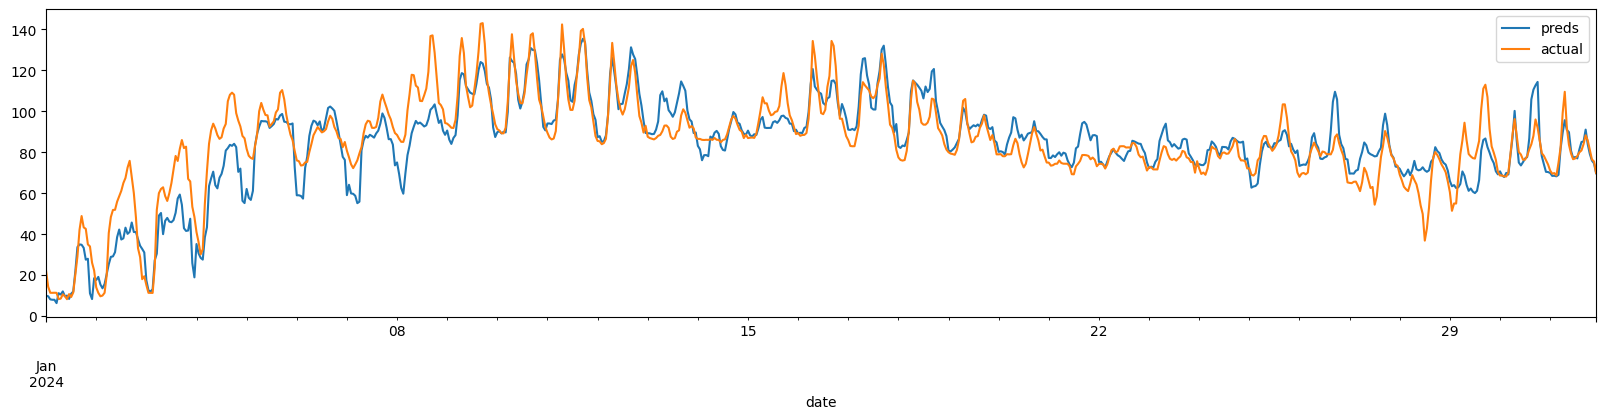

In [358]:
preds.plot(x="date", y=["preds", "actual"], figsize=(20, 4))

In [362]:
baseline = (
    df.assign(baseline=lambda x: x.day_ahead_price_ch.shift(24))
    .query("date.dt.date in @test_days")
    .filter(["date", "day_ahead_price_ch", "baseline"])
    .rename(columns={"baseline": "preds", "day_ahead_price_ch": "actual"})
)

In [363]:
print("Metric for LGBM Model")
print("R2 Score: ", r2_score(preds["actual"], preds["preds"]))
print("MAE: ", mean_absolute_error(preds["actual"], preds["preds"]))
print("MAPE: ", mean_absolute_percentage_error(preds["actual"], preds["preds"]))
print("RMSE: ", root_mean_squared_error(preds["actual"], preds["preds"]))

Metric for LGBM Model
R2 Score:  0.7806329595800214
MAE:  7.930385498094936
MAPE:  0.1077802920557366
RMSE:  10.84379788887118


In [364]:
print("Metric for baseline model")
print("R2 Score: ", r2_score(baseline["actual"], baseline["preds"]))
print("MAE: ", mean_absolute_error(baseline["actual"], baseline["preds"]))
print("MAPE: ", mean_absolute_percentage_error(baseline["actual"], baseline["preds"]))
print("RMSE: ", root_mean_squared_error(baseline["actual"], baseline["preds"]))

Metric for baseline model
R2 Score:  0.693600766406421
MAE:  8.569030955585465
MAPE:  0.11511246599495328
RMSE:  12.815618294665404


### ElasticNet

In [ ]:
preds = []
lookback_days = 30

for current_day in tqdm(test_days):
    train_start_day = current_day - pd.Timedelta(days=lookback_days)
    train_end_day = current_day - pd.Timedelta(days=1)
    
    df_train = df.query("@train_start_day <= date.dt.date <= @train_end_day")
    df_test = df.query("date.dt.date == @current_day")
    
    # Split data
    X_train = df_train.drop(columns=["date", "day_ahead_price_ch"])
    y_train = df_train["day_ahead_price_ch"]

    X_test = df_test.drop(columns=["date", "day_ahead_price_ch"])
    y_test = df_test["day_ahead_price_ch"]

    # Preprocess data
    fitted_preprocessor = preprocessor.fit(X_train)

    X_train_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_train),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    X_test_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_test),
        columns=fitted_preprocessor.get_feature_names_out(),
    )
    
    # Replace prefixes in column names
    new_cols = X_train_preprocessed.columns.str.replace('numeric__', '').str.replace('categorical__', '').str.replace('remainder__', '')

    # Assign new column names to the DataFrame
    X_train_preprocessed.columns = new_cols
    X_test_preprocessed.columns = new_cols

    # Scale data
    scaler = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train_preprocessed)
    X_test_preprocessed = scaler.transform(X_test_preprocessed)

    # Create ElasticNet Model
    model = ElasticNet()
    model.fit(X_train_preprocessed, y_train)

    # Make predictions on validation set
    y_pred = model.predict(X_test_preprocessed)

    preds.extend(y_pred.tolist())

  0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
preds = pd.DataFrame({
    "date": df.query("date.dt.date in @test_days")["date"].to_list(),
    "preds": preds,
    "actual": df.query("date.dt.date in @test_days")["day_ahead_price_ch"].to_list()
})

<Axes: xlabel='date'>

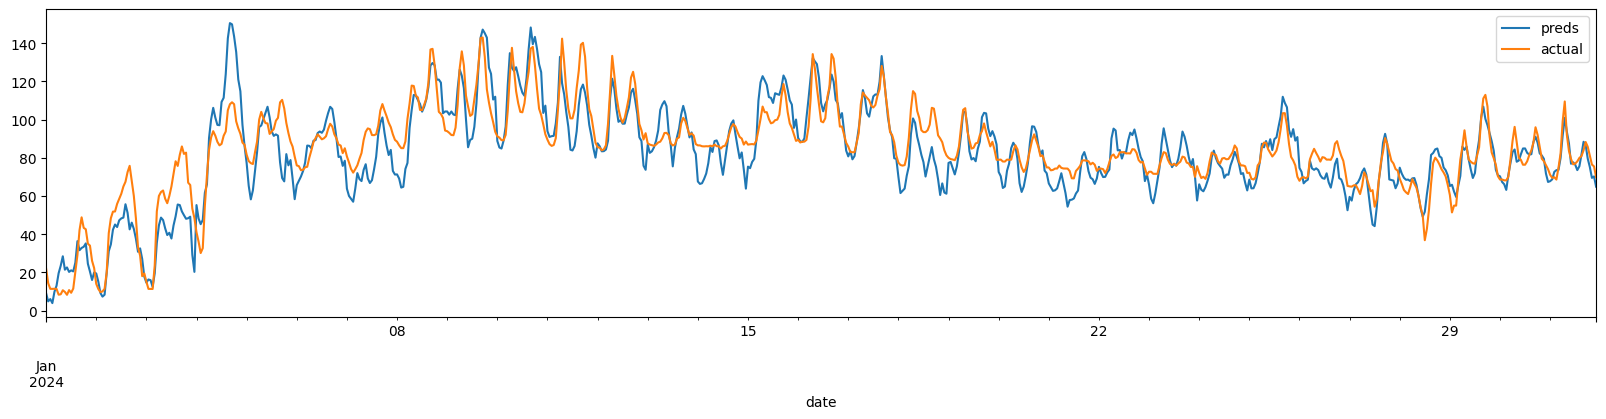

In [ ]:
preds.plot(x="date", y=["preds", "actual"], figsize=(20, 4))

In [ ]:
baseline = (
    df.assign(baseline=lambda x: x.day_ahead_price_ch.shift(24))
    .query("date.dt.date in @test_days")
    .filter(["date", "day_ahead_price_ch", "baseline"])
    .rename(columns={"baseline": "preds", "day_ahead_price_ch": "actual"})
)

In [ ]:
print("Metric for ElasticNet Model")
print("R2 Score: ", r2_score(preds["actual"], preds["preds"]))
print("MAE: ", mean_absolute_error(preds["actual"], preds["preds"]))
print("MAPE: ", mean_absolute_percentage_error(preds["actual"], preds["preds"]))
print("RMSE: ", root_mean_squared_error(preds["actual"], preds["preds"]))

Metric for ElasticNet Model
R2 Score:  0.7633488571982341
MAE:  8.614326229099248
MAPE:  0.12355483453218244
RMSE:  11.262894846406757


In [ ]:
print("Metric for baseline model")
print("R2 Score: ", r2_score(baseline["actual"], baseline["preds"]))
print("MAE: ", mean_absolute_error(baseline["actual"], baseline["preds"]))
print("MAPE: ", mean_absolute_percentage_error(baseline["actual"], baseline["preds"]))
print("RMSE: ", root_mean_squared_error(baseline["actual"], baseline["preds"]))

Metric for baseline model
R2 Score:  0.693600766406421
MAE:  8.569030955585465
MAPE:  0.11511246599495328
RMSE:  12.815618294665404
